In [1]:
#Imports
import wandb
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
from diffusers import DDPMScheduler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMPipeline
import os
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
from dataclasses import dataclass
import torch.distributions as D
from diffusers.pipeline_utils import DiffusionPipeline, ImagePipelineOutput
import torch.nn as nn

/home/shervink/miniconda3/envs/dpok/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-05-15 23:10:06,307] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/shervink/miniconda3/envs/dpok/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/shervink/miniconda3/envs/dpok/compiler_compat/ld: cannot find -lcufile: No such file or directory
collect2: error: ld returned 1 exit status


In [10]:
#Configuration of Training hyperparameters
@dataclass

class TrainingConfig:

    adaptation = False #If adaptation = True, the problem will be treated as a adaptation/fine-tuning problem where we want to adapt a pre-trained model to new data without overfitting.

    image_size = 32 # the generated image resolution (the training data will be resized to image_size*image_size)
    latent_size = 32 # Latent resolution (ignore if not using latent diffusion)
    diffusion_channels = 1 #1 for b&w images, 3 for RGB, 4 or more for latent diffusion

    primal_batch_size = 128 #number of images in each mini-batch sampled for computing the primal loss
    dual_batch_size = 64 #number of images in each mini-batch sampled for computing each constraint loss
    eval_batch_size = 64 # how many samples to sample during evaluation step

    num_epochs = 100 #number of total epochs
    batches_per_epoch = 4 #number of mini-batches per epoch
    primal_per_dual = 5 #number of primal descent steps after each update of the dual variables
    
    save_model_epochs = 30 # number of epochs between each time the model is saved
    save_plot_epochs = 20 # number of epochs between each time plots of relevant variables are saved
    save_image_epochs = 10 # number of epochs between each time a batch of images generated by the diffusion model are saved
    running_average_length = 5 #length of the running average for plotting average histograms of generated samples during training

    num_gpus = 2 #number of gpus to split the training on using the 'accelerate' library

    load_model_header = 'MODEL_NAME' # header of the initial model to load from the 'save_models_dir' directory. used if continuing training of a previusly trained model or fine-tuning a pre-trained model.
    save_model_header = 'saved' # header to save the model with 

    gradient_accumulation_steps = 1

    lr_primal = 1e-5 # the maximum primal learning rate
    lr_dual = 1.0 #ratio of dual learning rate to primal learning rate
    lr_warmup_steps = 500 # number of warmup steps to use in the learning rate scheduler

    evaluate = True #set to True if you want the model to sample images from the diffusion model after every #save_image_epochs steps.
    wandb_logging = False #set to True if you want to log relevant variables to wandb

    architecture_size = 128 # the size of the denoising U-net model can be scaled up or down using this parameter

    
    dataset_name = 'mnist' #name of the dataset to use for training. could be one of ['mnist', 'celeb-a', 'image-net']

    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision

    upload_to_github = True #If True, in addition to saving plots and imgs to file, will upload them to github repo
    github_token = " "
    github_repo = " "

    output_dir = "FOLDER_NAME"  # the local directory name to save everything
    save_models_dir = "models" # the local directory to save trained models
    
    T = 100 #number of diffusion steps

config = TrainingConfig()

In [11]:
#Function for sampling 2D data points from the diffusion model
def sample_images_ddpm(unet, scheduler, batch_size = 1, num_inference_steps = 1000):

    device = 'cuda:0'
    # Sample gaussian noise to begin loop
    
    unet.to(device)

    image_shape = (batch_size, 2)

    image = torch.randn(image_shape).to(device)

    # set step values
    scheduler.set_timesteps(num_inference_steps)

    for t in scheduler.timesteps:
        # 1. predict noise model_output
        model_output = unet(image)

        # 2. compute previous image: x_t -> x_t-1
        image = scheduler.step(model_output, t, image).prev_sample


    return image

In [12]:
#Gaussian Mixture Dataset Class

class GaussianMixtureDataset(Dataset):
    def __init__(self, means, covariances, num_samples = 1000, weights=None):
        """
        Initialize the dataset with a mixture of Gaussians.

        Parameters:
        - num_components (int): Number of Gaussian components in the mixture.
        - num_dimensions (int): Dimensionality of each sample.
        - num_samples (int): Total number of samples to generate.
        - means (torch.Tensor, optional): Means of the Gaussian components. Defaults to random values.
        - covariances (torch.Tensor, optional): Covariance matrices of the Gaussian components. Defaults to identity matrices.
        - weights (torch.Tensor, optional): Weights of the Gaussian components. Defaults to equal weights.
        """
        
        self.num_components = means.shape[0]
        self.num_dimensions = means.shape[1]
        
        self.num_samples = num_samples

        self.means = means
        
        self.covariances = covariances
        
        if weights is None:
            self.weights = torch.ones(self.num_components) / self.num_components  # Equal weights
        else:
            self.weights = weights
        
        # Create the mixture distribution
        self.mixture_distribution = D.Categorical(self.weights)
        self.component_distribution = D.MultivariateNormal(self.means, self.covariances)
        self.gmm = D.MixtureSameFamily(self.mixture_distribution, self.component_distribution)
        
    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Generate a sample from the mixture distribution
        sample = self.gmm.sample()
        return sample

In [5]:
#Resnet Block for 2D data
class ResNetBlock2D(nn.Module):
    """
    A single ResNet block for 2D data with multiple fully connected layers.
    """
    def __init__(self, hidden_dim=20):
        super(ResNetBlock2D, self).__init__()
        self.hidden_dim = hidden_dim
        
        # Define layers with bias terms
        self.fc1 = nn.Linear(2, self.hidden_dim, bias=True)
        self.fc2 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.fc3 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.fc4 = nn.Linear(self.hidden_dim, 2, bias=True)
        
        # Initialize biases to zero
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)
        nn.init.zeros_(self.fc4.bias)

    def forward(self, x):
        identity = x  # Save input for residual connection

        # Pass through layers with ReLU activations
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        # Add residual connection
        x = x + identity

        return x

In [6]:
#Train Loop Function
def train_loop(config, model, noise_scheduler, optimizer, train_dataloaders, lr_scheduler, init_mus = None, b = None):

    
    # Create a figure with 10 subplots (2 rows, 5 columns)
    # fig, axes = plt.subplots(int(config.num_epochs/config.save_plot_epochs//5), 5, figsize=(15, 3*int(config.num_epochs/config.save_plot_epochs//5)))
    # axes = axes.flatten()  # Flatten the axes array for easier iteration

    # Initialize the figure
    
    loss_hist = np.zeros(config.num_epochs)
    
    
    
    
    
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="wandb" if config.wandb_logging else None,
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if config.wandb_logging:
        accelerator.init_trackers(
                project_name="simple_constrained_diffusion_tests",
                config=config,
            )
    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, lr_scheduler = accelerator.prepare(
        model, optimizer, lr_scheduler
    )
    

    #Nc is the number of constraints here
    Nc = len(train_dataloaders)
    
    nc = np.zeros(Nc)

    if init_mus is not None:
        mu = init_mus
    else:
        mu = 1/Nc*torch.ones(Nc, requires_grad = False).to(accelerator.device)
    
    if b is not None:
        b = b
    else:
        b = torch.zeros(Nc, requires_grad = False).to(accelerator.device)
    
    
    dataloaders = []
    iterators = []

    #prepare all the dataloaders
    for k in range(len(train_dataloaders)):
        dataloaders += [accelerator.prepare(train_dataloaders[k])]
        iterators += [cycle(dataloaders[k])]

    global_step = 0

    # Now you train the model
    
    progress_bar = tqdm(total=config.num_epochs, disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Training Progress")
    
    
        
    for epoch in range(config.num_epochs):
        

        for step in range(config.batches_per_epoch):

            Clean_images = []
            Noises = []
            Batch_sizes = []
            Timesteps = []
            Noisy_images = []
            Noise_preds = []

            for k in range(Nc):

                device = accelerator.device

                train_features = next(iterators[k])
                Clean_images += [train_features.to(device)]
                Noises += [torch.randn(Clean_images[k].shape, device = Clean_images[k].device)]
                Batch_sizes += [Clean_images[k].shape[0]]
                Timesteps += [torch.randint(
                            0, config.T, (Batch_sizes[k],), device = Clean_images[k].device,
                            dtype = torch.int64
                        )]
                Noisy_images += [noise_scheduler.add_noise(Clean_images[k], Noises[k], Timesteps[k])]


            with accelerator.accumulate(model):

                Losses = []

                #The Lagrangian
                lag = torch.zeros(1, requires_grad = False).to(device)

                for l in range(Nc):
                                  
                    Noise_preds += model(Noisy_images[l].unsqueeze(0))


                    Losses += [F.mse_loss(Noise_preds[l], Noises[l])]

                    #The Lagrangian
                    lag += mu[l]*Losses[l]
                    
                    

                

                accelerator.backward(lag)
                
                # if ((epoch + 1)%config.primal_per_dual == 0):
                #     lagrangian_hist[i_hist] = lag.detach()
                
                ############### DUAL STEP START #############
                current_lr = lr_scheduler.get_last_lr()[0]
                
                m = mu.shape[0]

                if (epoch + 1)%config.primal_per_dual == 0:
                    
                    lr_dual = config.lr_dual
                    l = torch.tensor(Losses, requires_grad = False).to(mu.device)
                    b = b.to(mu.device)
                    grad = lr_dual*(l - b)
                    
                    if torch.linalg.norm(grad).detach() != 0:
                        grad_proj = grad - (torch.sum(grad*torch.ones_like(grad)/np.sqrt(m)))*torch.ones_like(grad)/np.sqrt(m)
                    else:
                        grad_proj = grad
                        
                    mu = (mu + grad_proj).detach()
                        
                    mu = torch.minimum(mu, torch.ones_like(mu))
                    
                    mu = torch.maximum(mu, torch.zeros_like(mu))
                    
                ################ DUAL STEP END ###############
                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
        if config.wandb_logging:
            accelerator.log({"lagrangian": lag}, step = epoch)
            
            for k in range(mu.shape[0]):
                accelerator.log({"mu " + str(k + 1): mu[k]}, step = epoch)
                accelerator.log({"loss " + str(k + 1): Losses[k]}, step = epoch)
                
        progress_bar.update(1)
            
        if epoch%config.save_plot_epochs == 0 and accelerator.is_main_process:
            
        
            # Create loss curve plot
            fig, ax = plt.figure(figsize=(10, 10)), plt.gca()
            
            images =( sample_images_ddpm(model, noise_scheduler, batch_size = 5000, num_inference_steps = config.T)).detach().cpu().numpy()
            
            ax.hist2d(images[:, 0], images[:, 1], bins=50, cmap=plt.cm.binary)
            ax.set_xlim(-2.5, 2.5)
            ax.set_ylim(-2.5, 2.5)
            
            
            
           
            # Log the plot
            # For Weights & Biases
            if config.wandb_logging:
                fig = wandb.Image(fig)
                accelerator.log({"Generated Samples Histogram": fig}, step = epoch)

            
        
            nc[0] = np.sum(images[:, 1] < 0)
            nc[1] = np.sum(images[:, 1] > 0)
            
            for k in range(Nc):
                if config.wandb_logging:
                    accelerator.log({"nc " + str(k + 1): nc[k]}, step = epoch)

            
            
    if accelerator.is_main_process and hasattr(accelerator, "trackers") and accelerator.trackers:
        accelerator.end_training()

Launching training on one GPU.


Training Progress: 100%|██████████| 300/300 [00:24<00:00, 12.38it/s]

lagrangian,█▂▃▃▅▄▅▃▄▂▂▄▁▄▃▃▂▄▁▄▄▄▃▁▃█▃▇▄▃▃▆▃▅▄▂▁▃▃▂
loss 1,█▄▃▅▃▄▄▃▄▄▄▄▅▆▅▄▅▁▇▄▂▆▇▅▂▁▃▅▄▄▆▄▅▅▄▃▄▅▆▅
loss 2,▄▄▆▁▃▃▅▄▅▂▄▅▃▆▃▃▇▄▄▆█▅▃▂▄▃▄▂▃▇▆▇▂▄▁▃▄▅▄▆
mu 1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mu 2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nc 1,█▆▅▄▁▆█▅▆▆▆▅▄▂▄▄▅▃▄▅▅▅▆▅▄▄▅▅▃▄
nc 2,▁▃▄▅█▃▁▄▃▃▃▄▅▇▅▅▄▆▅▄▄▄▃▄▅▅▄▄▆▅
lagrangian,0.38425
loss 1,0.32016
loss 2,0.44835
mu 1,0.5


/home/shervink/miniconda3/envs/dpok/lib/python3.7/site-packages/wandb/sdk/wandb_run.py:2386: UserWarning: Run (x8bdcb7n) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
Training Progress: 100%|██████████| 300/300 [00:27<00:00, 11.00it/s]


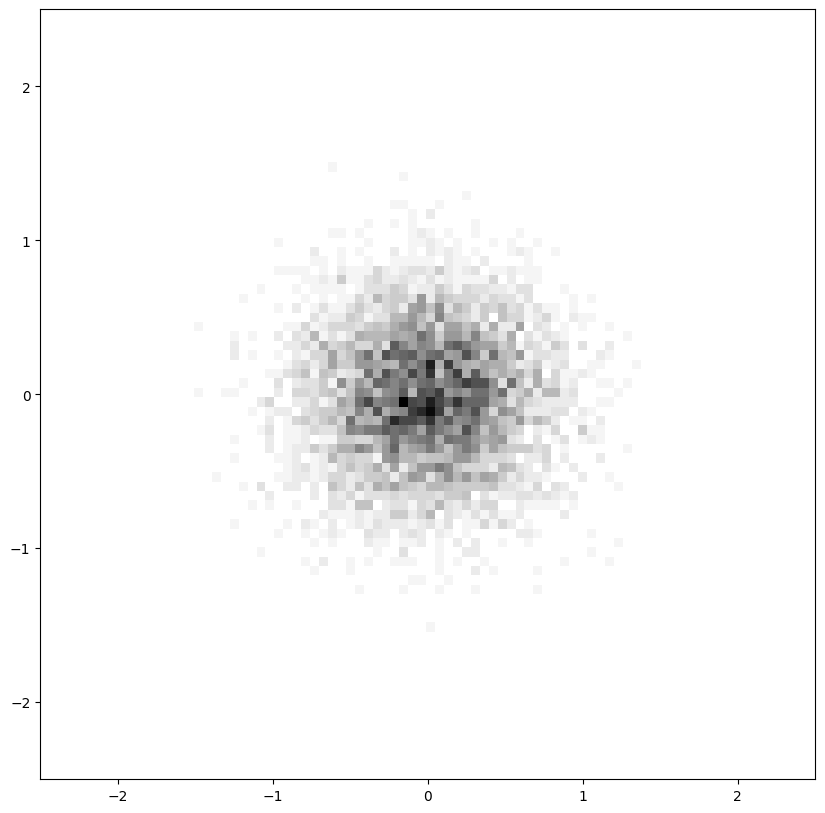

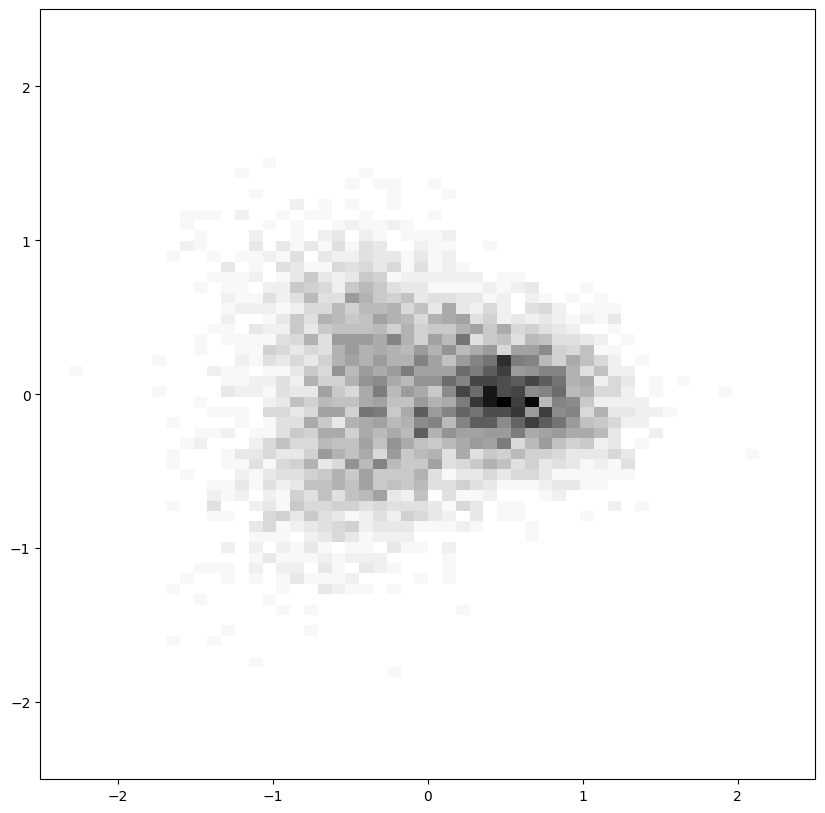

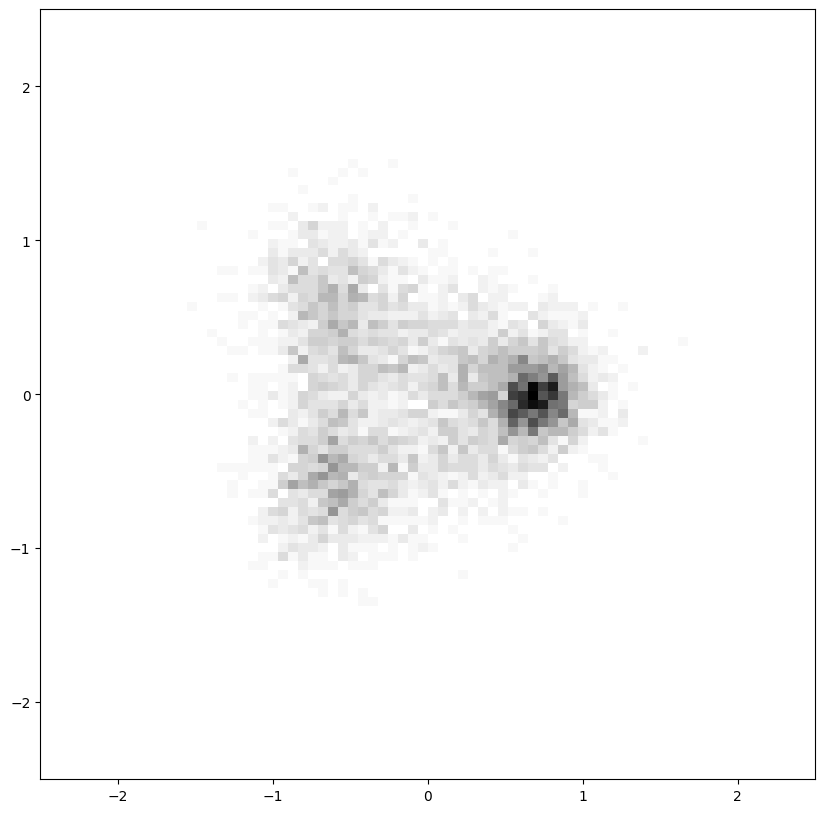

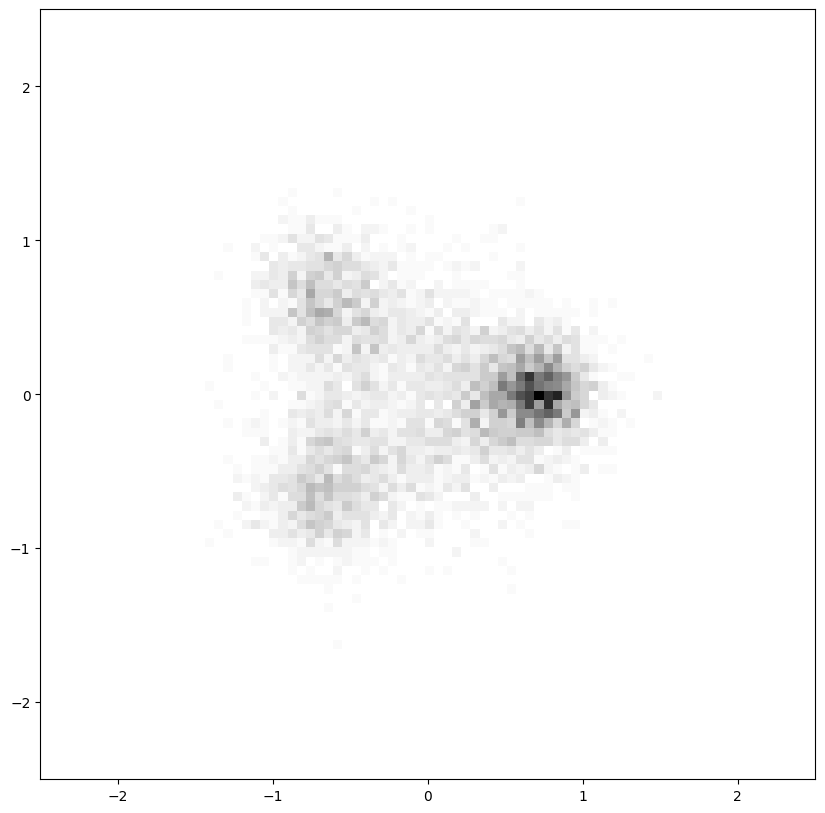

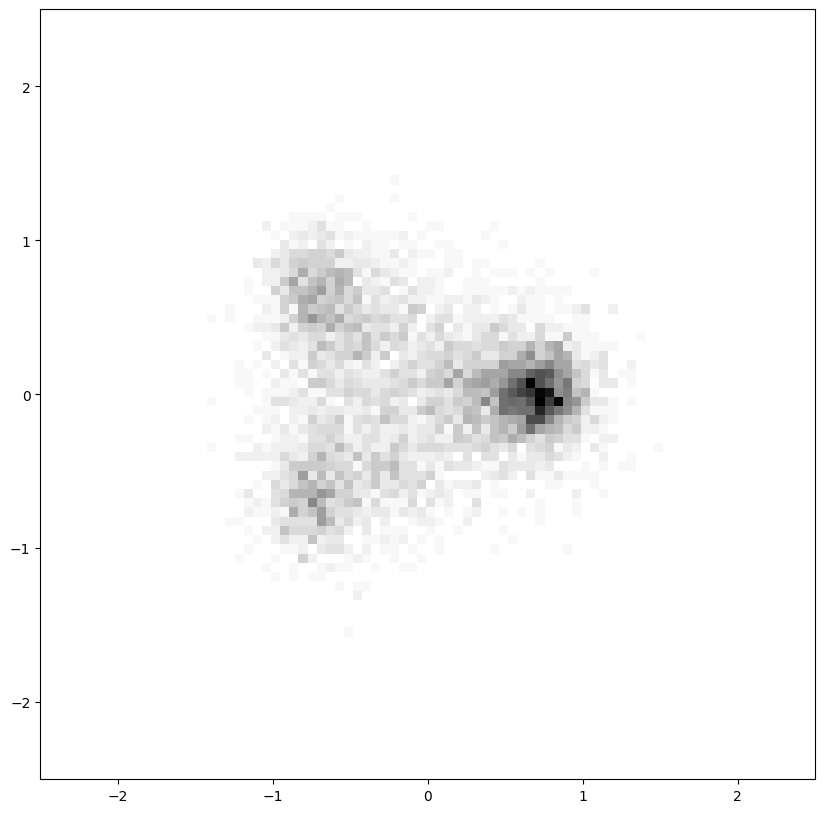

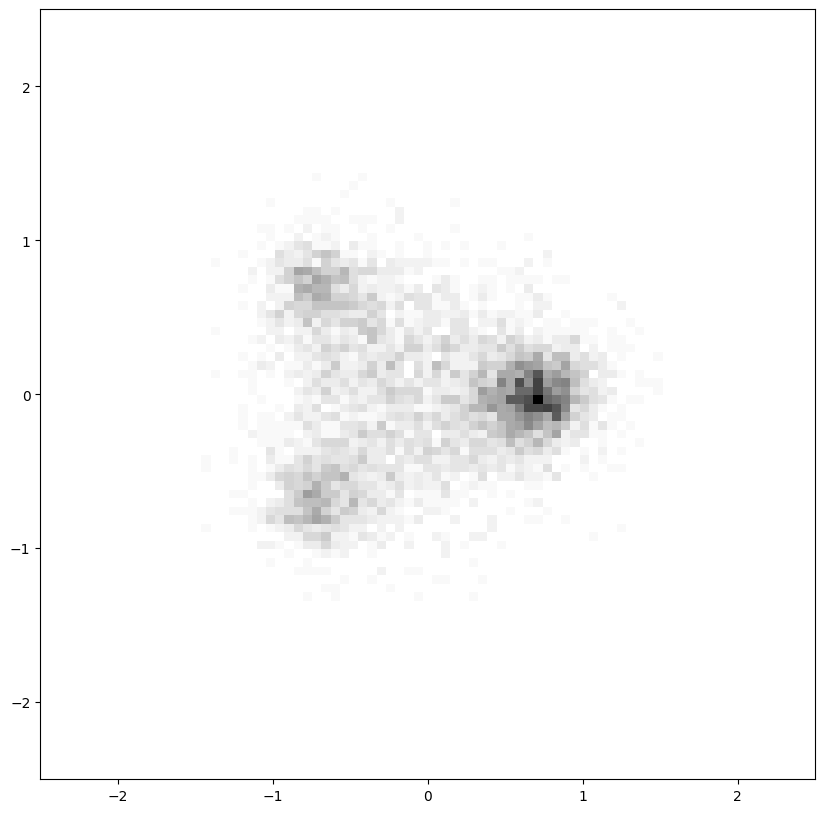

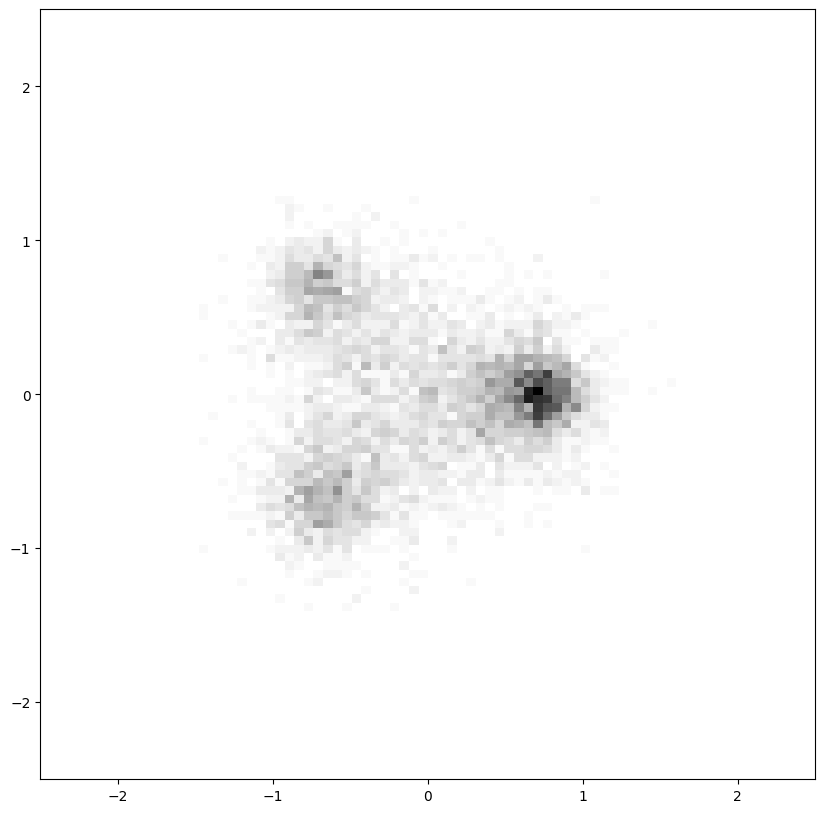

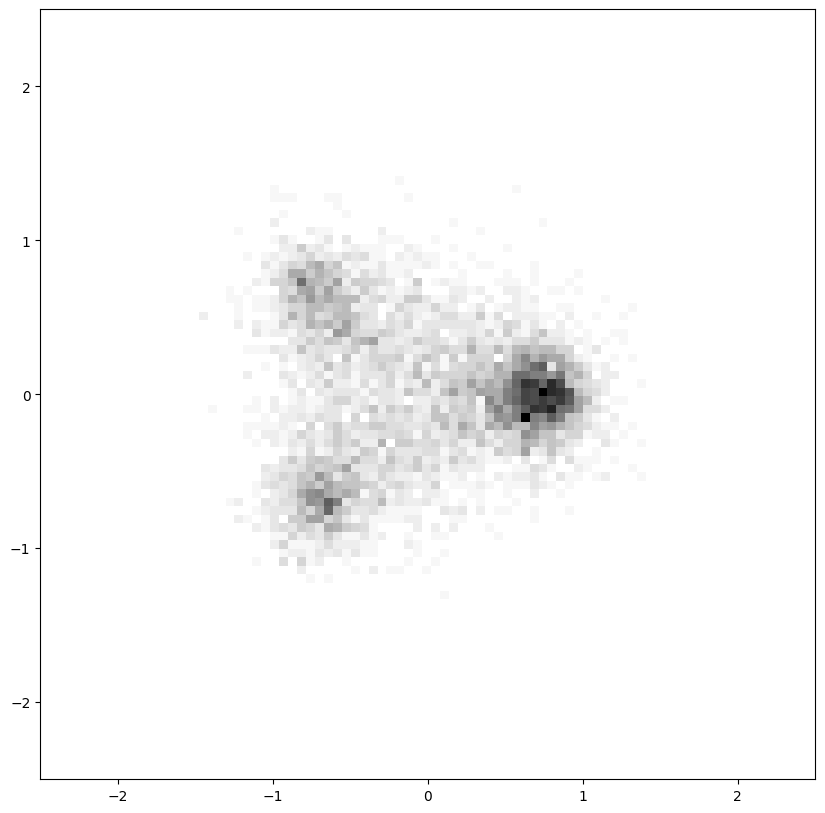

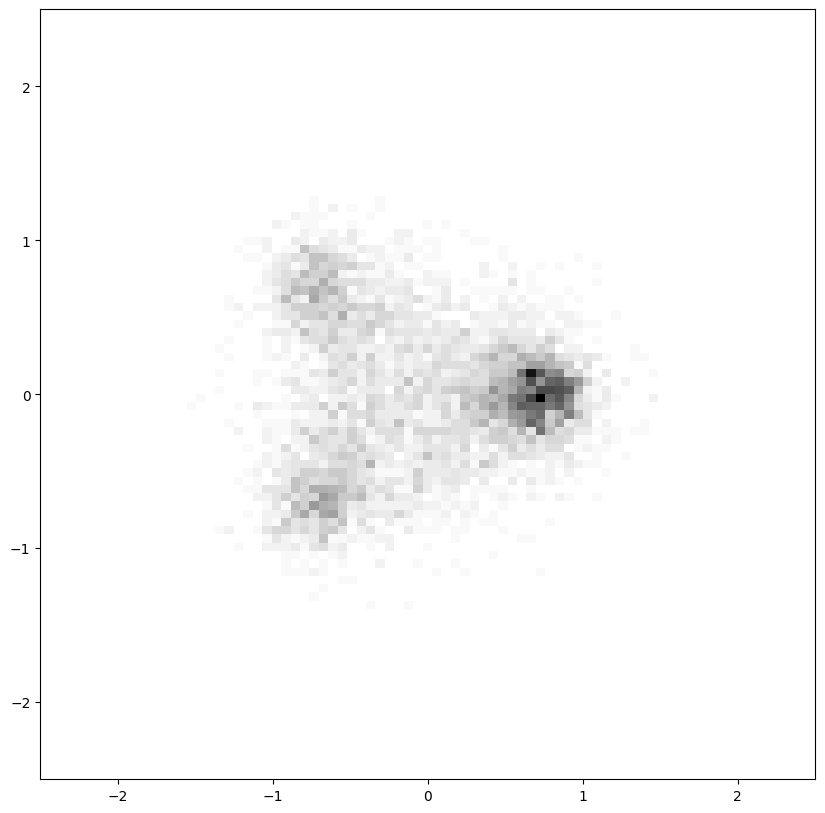

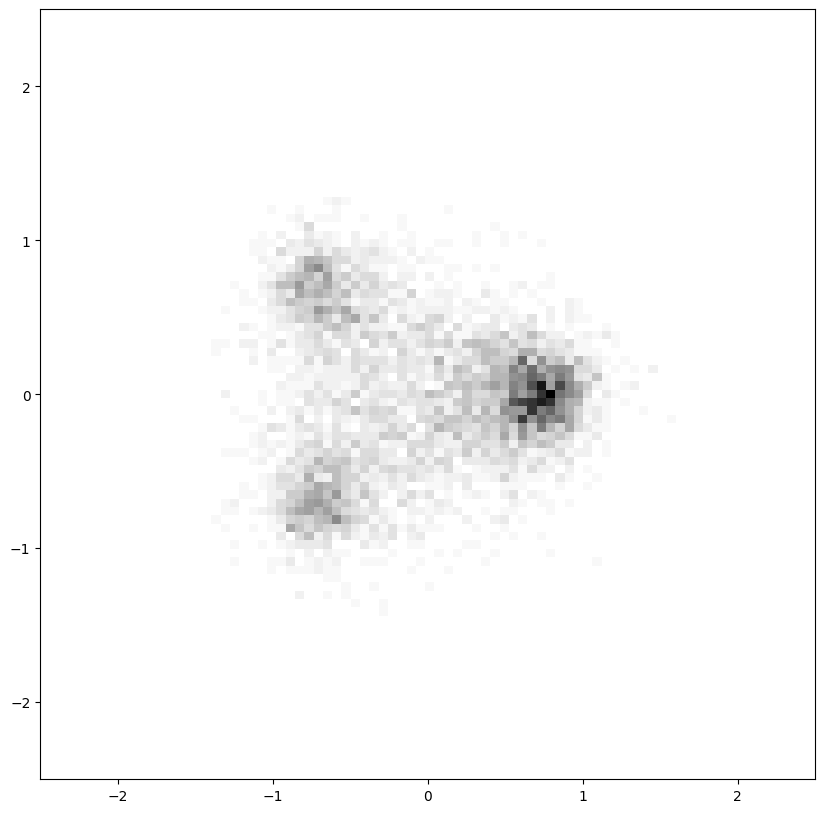

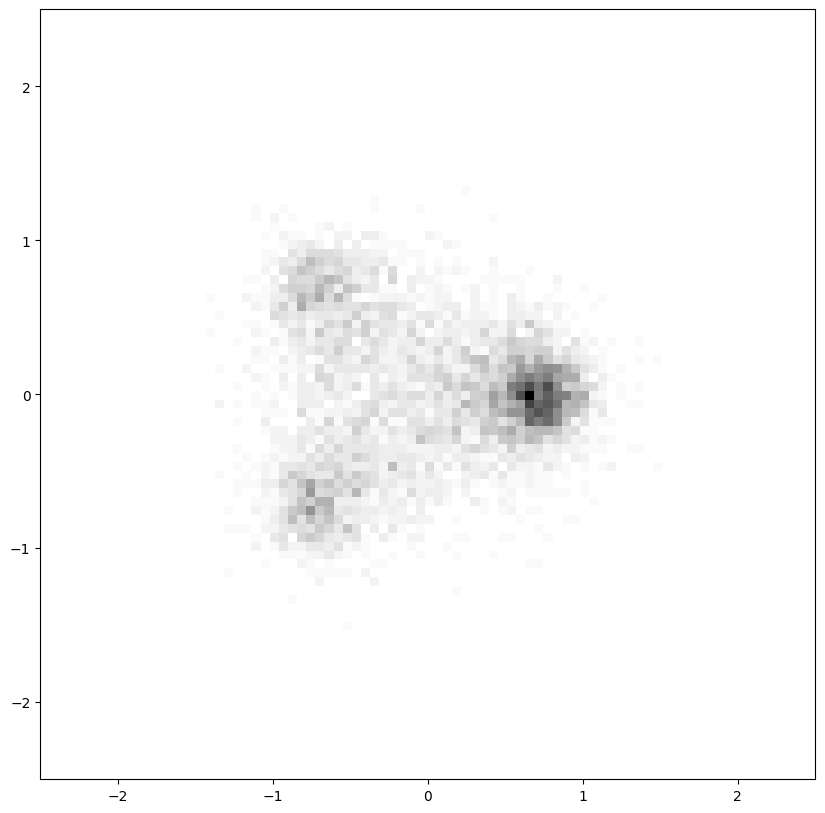

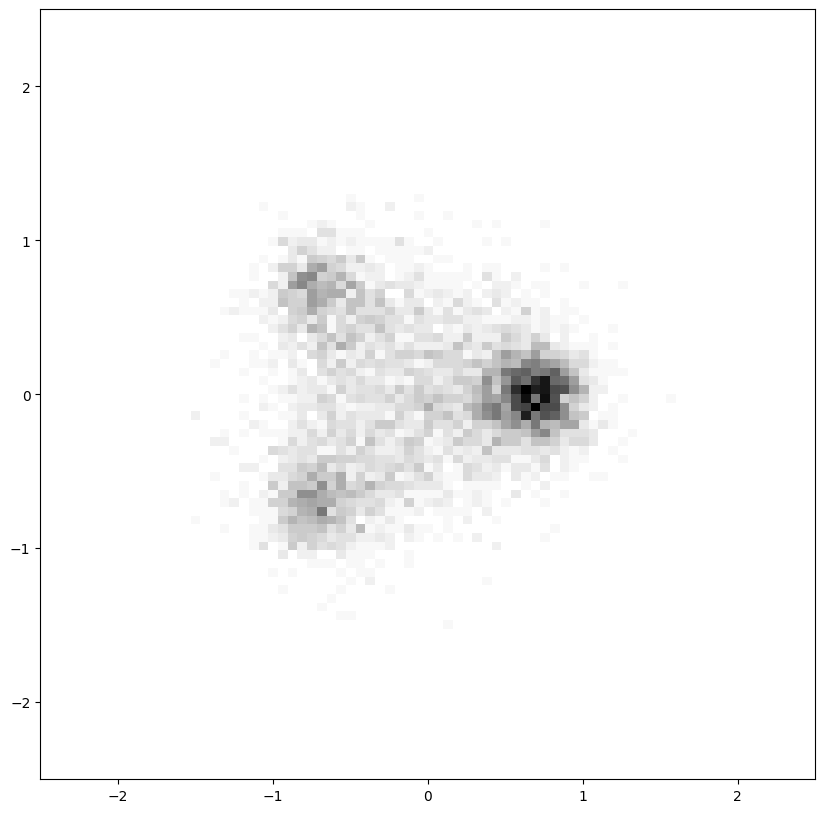

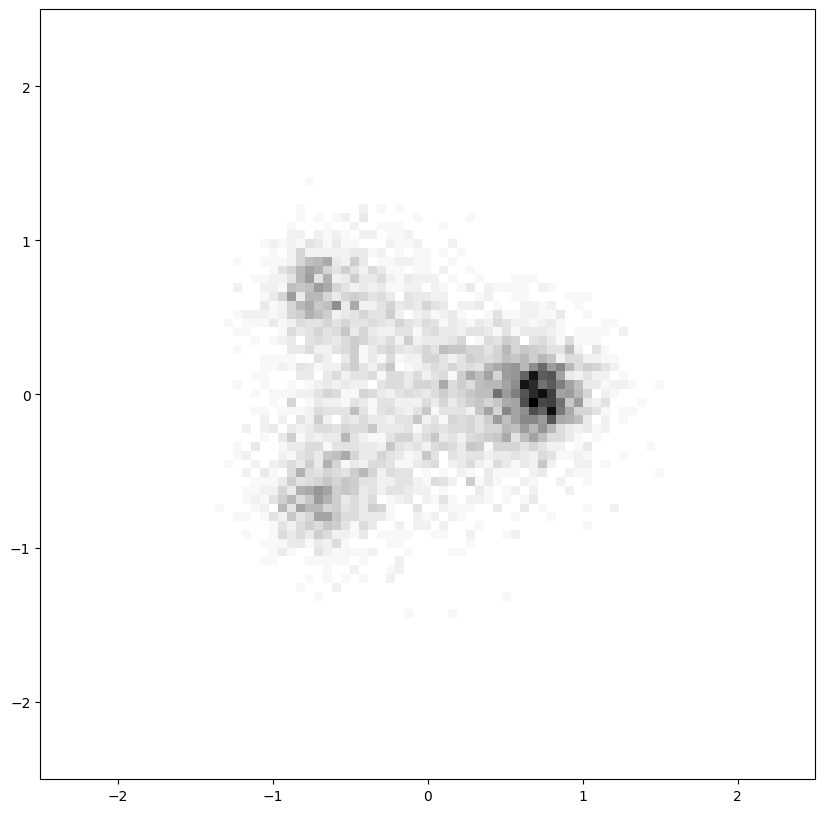

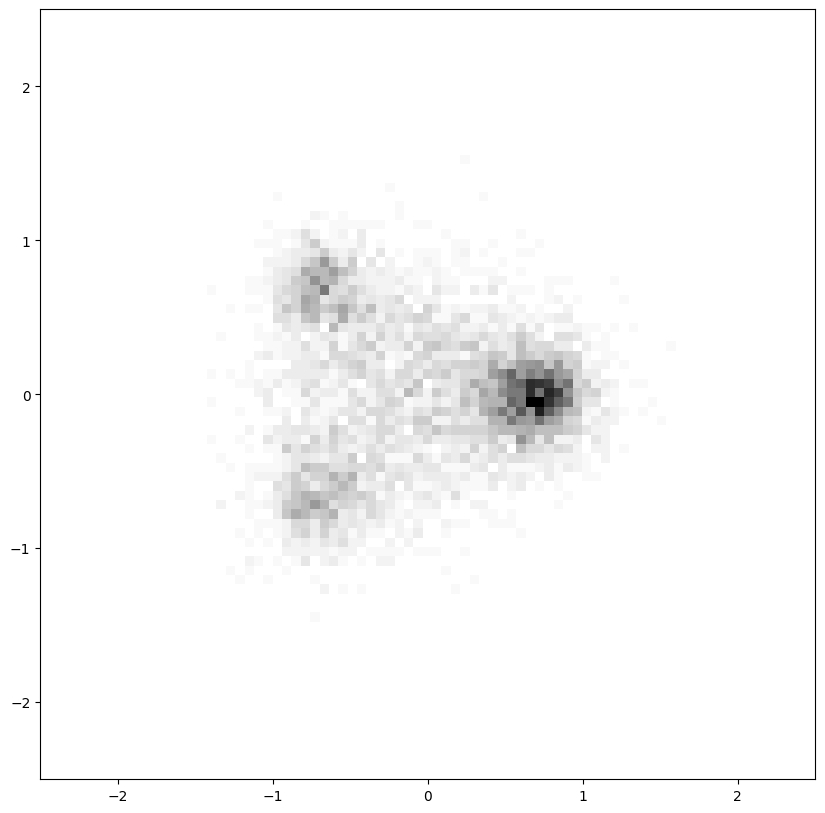

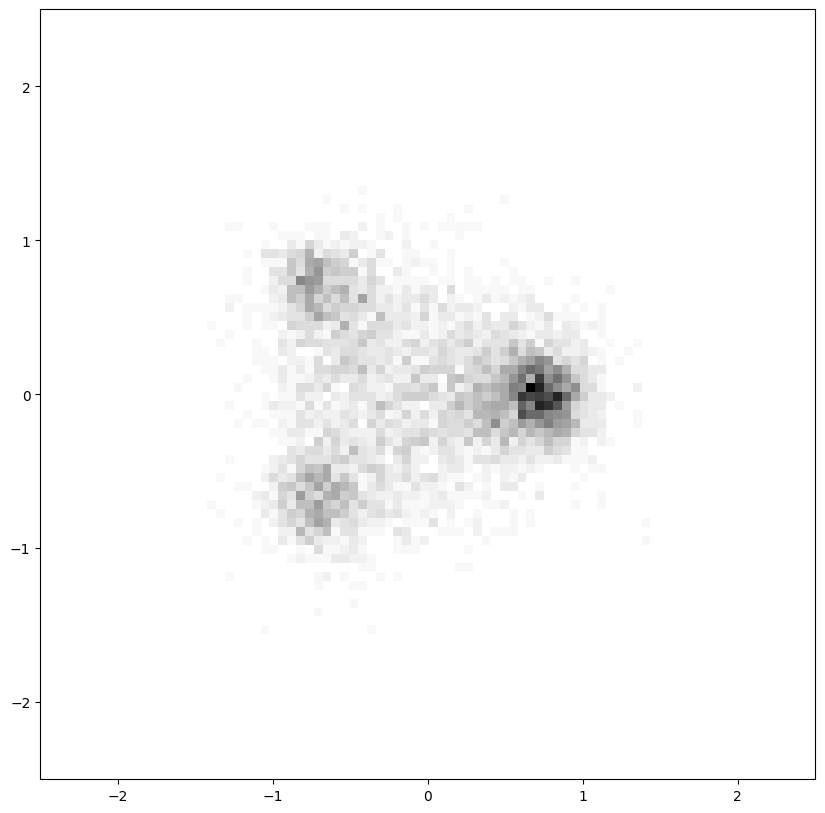

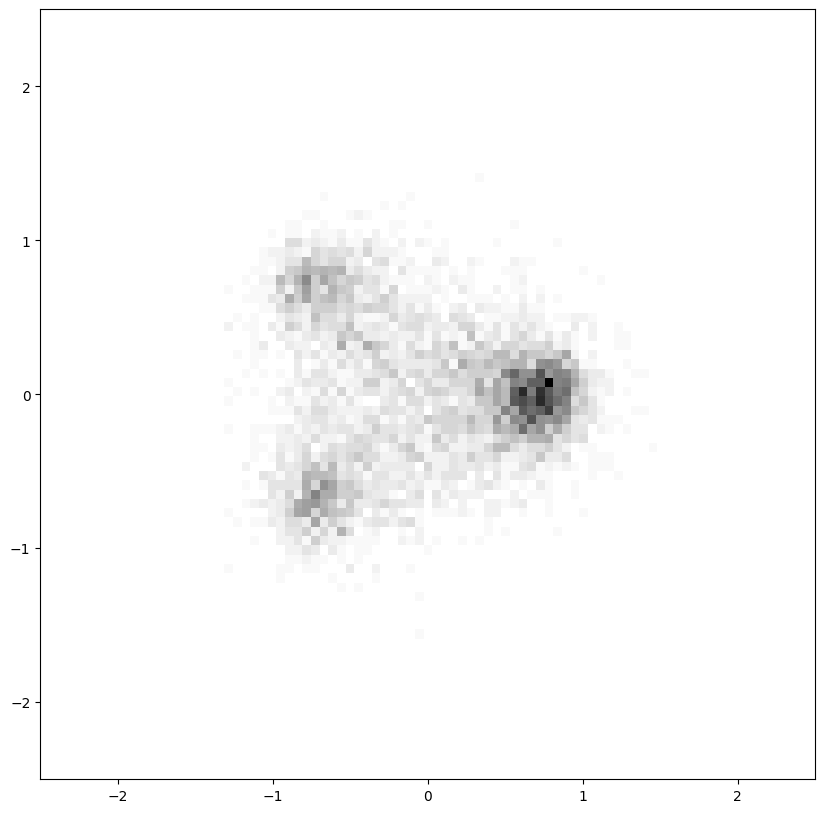

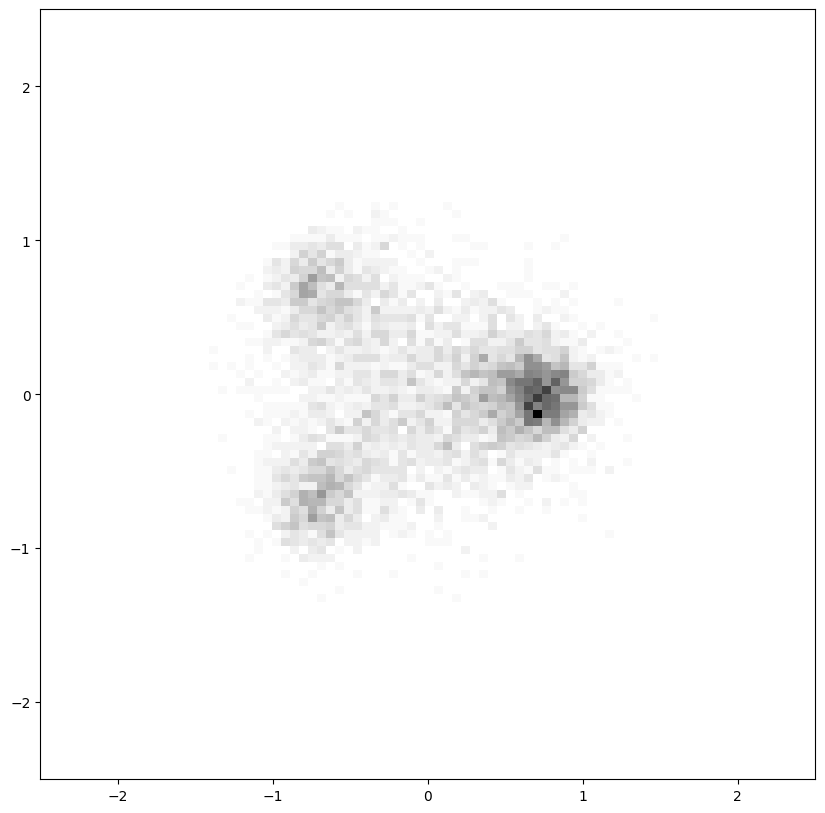

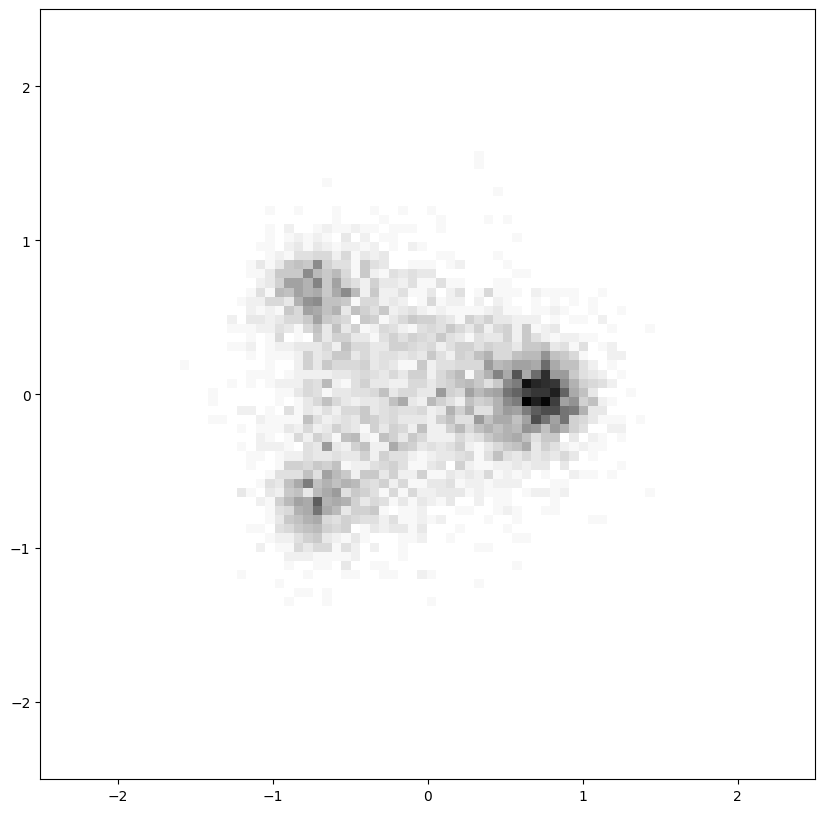

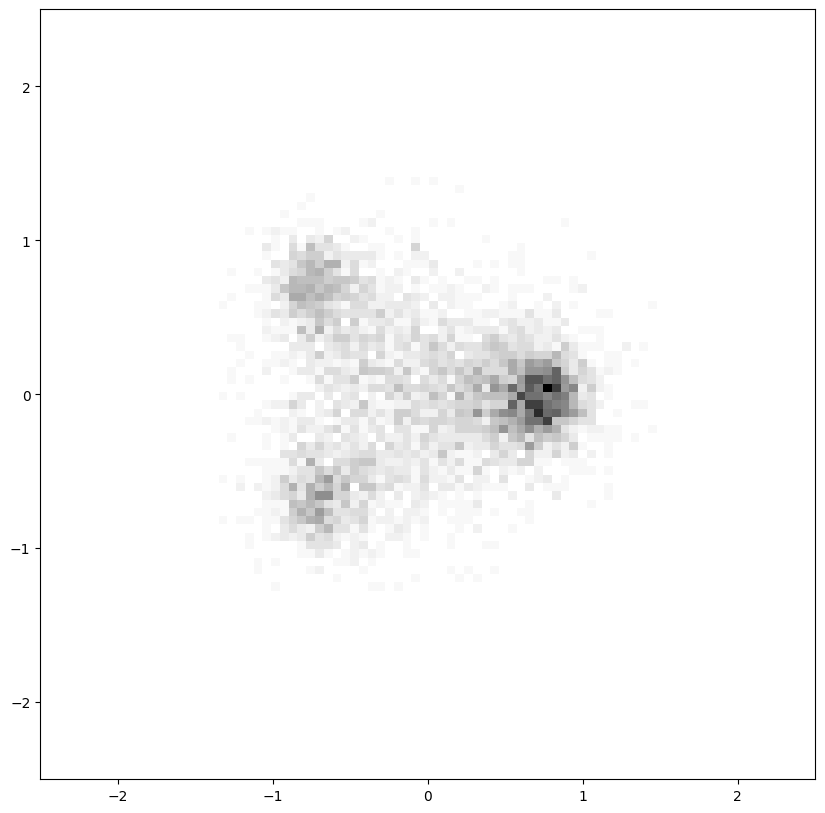

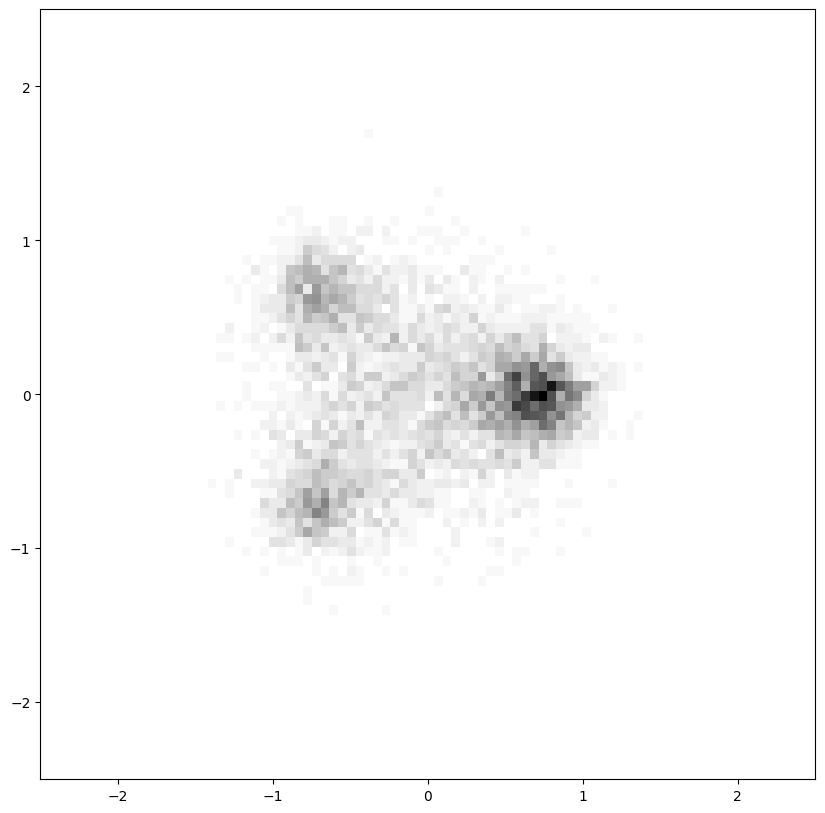

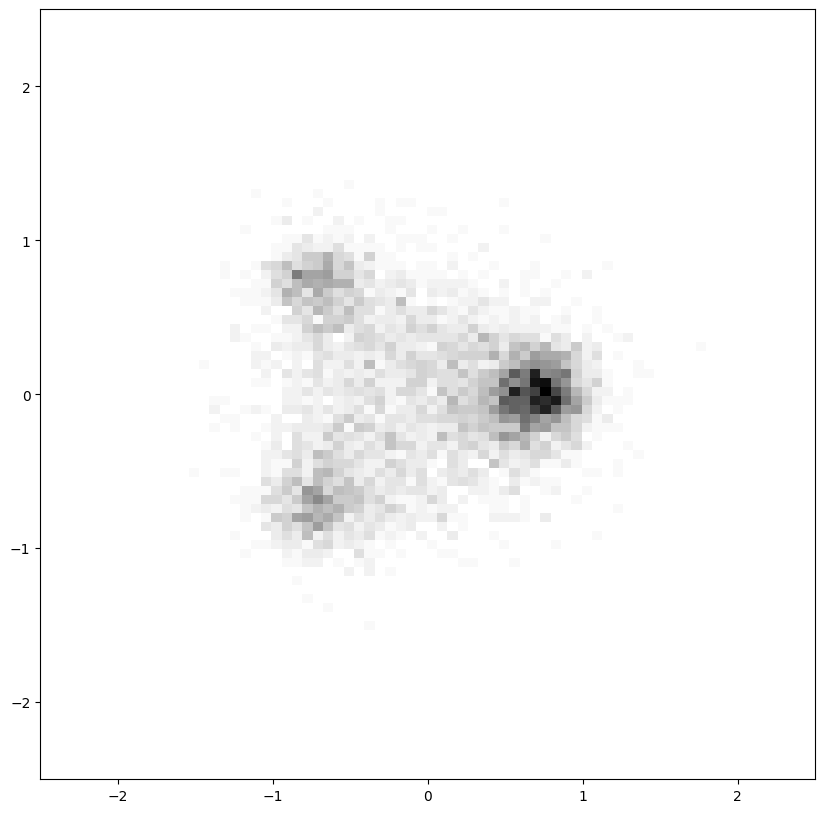

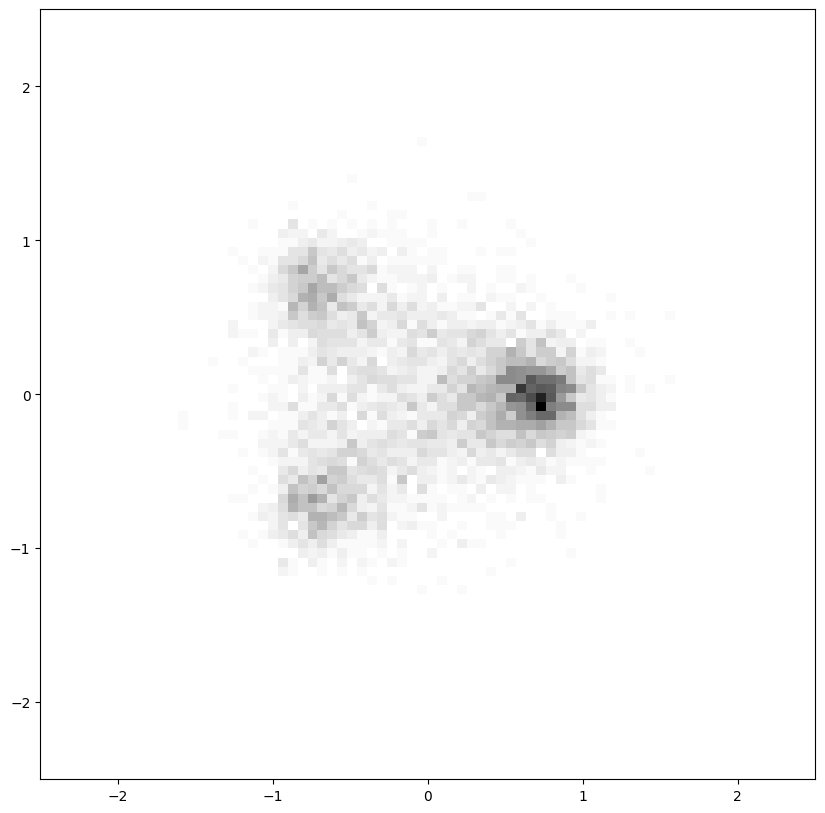

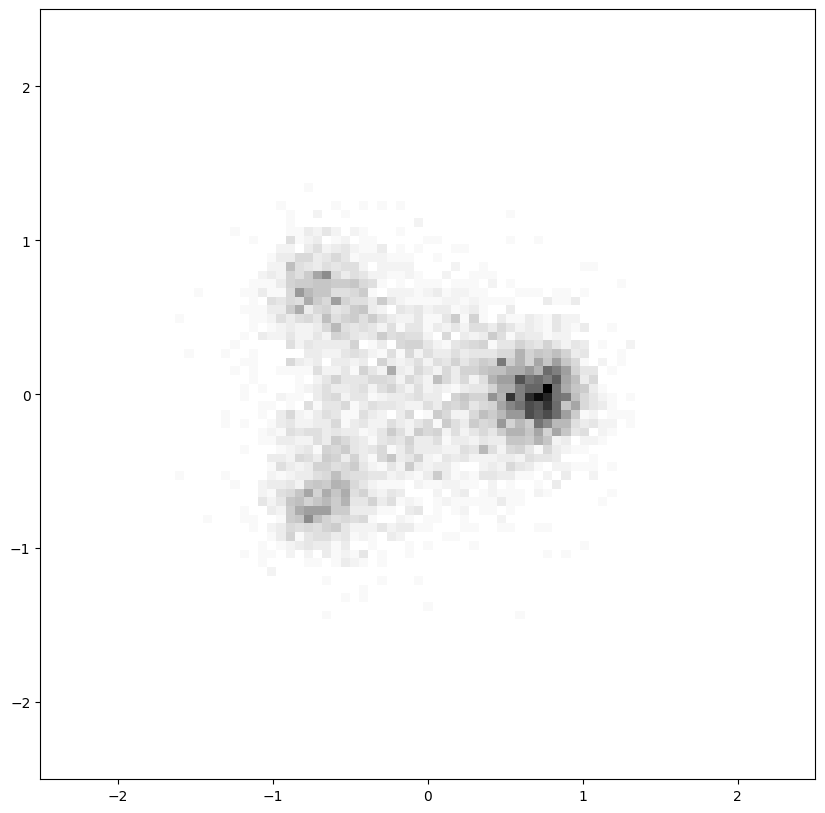

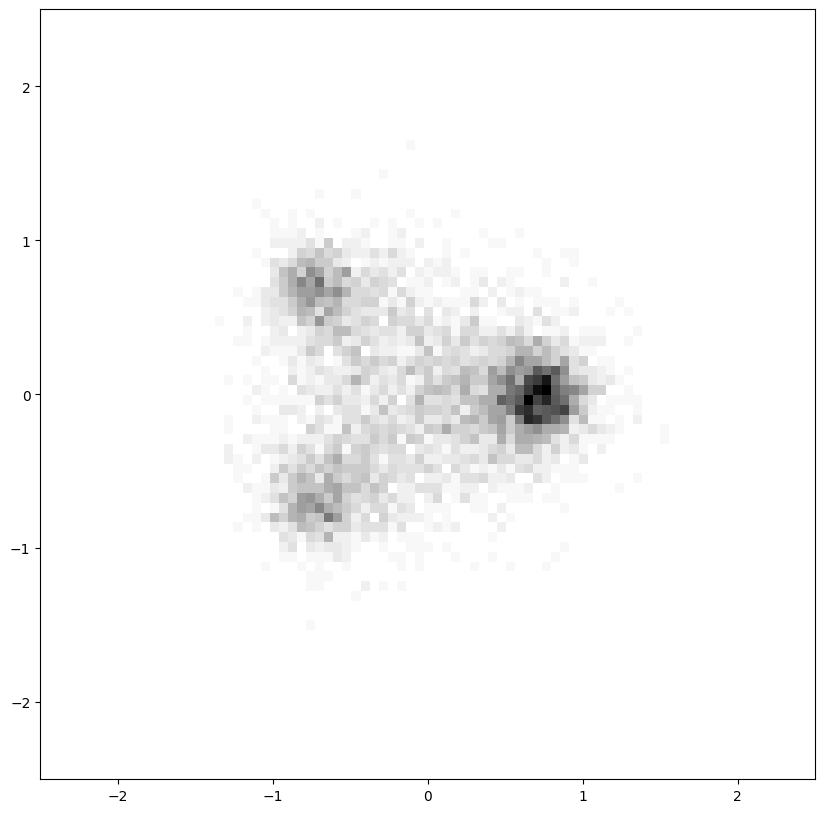

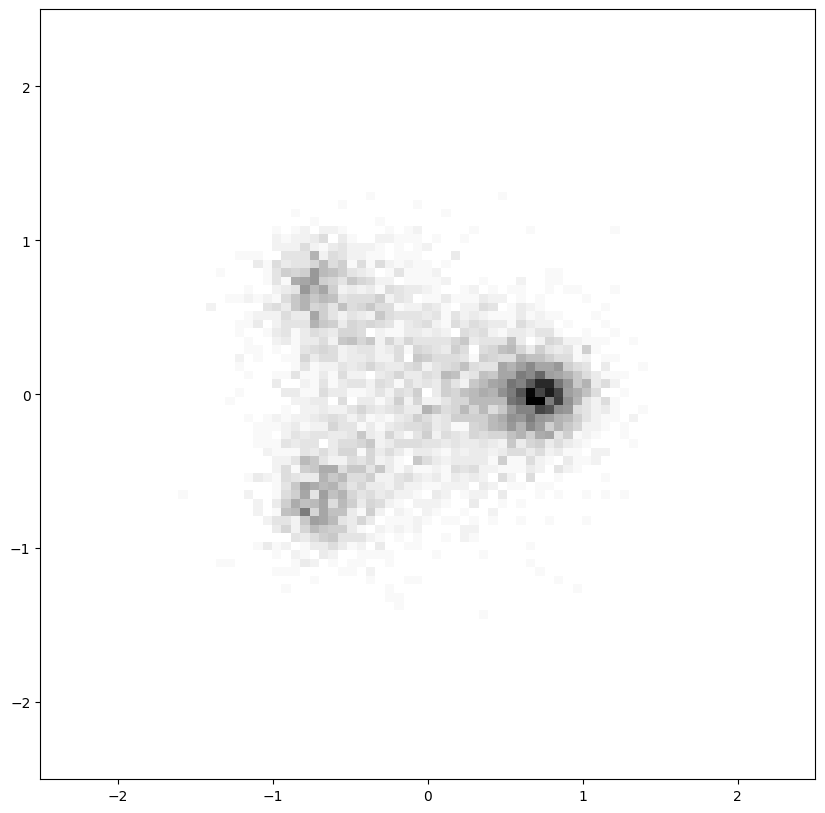

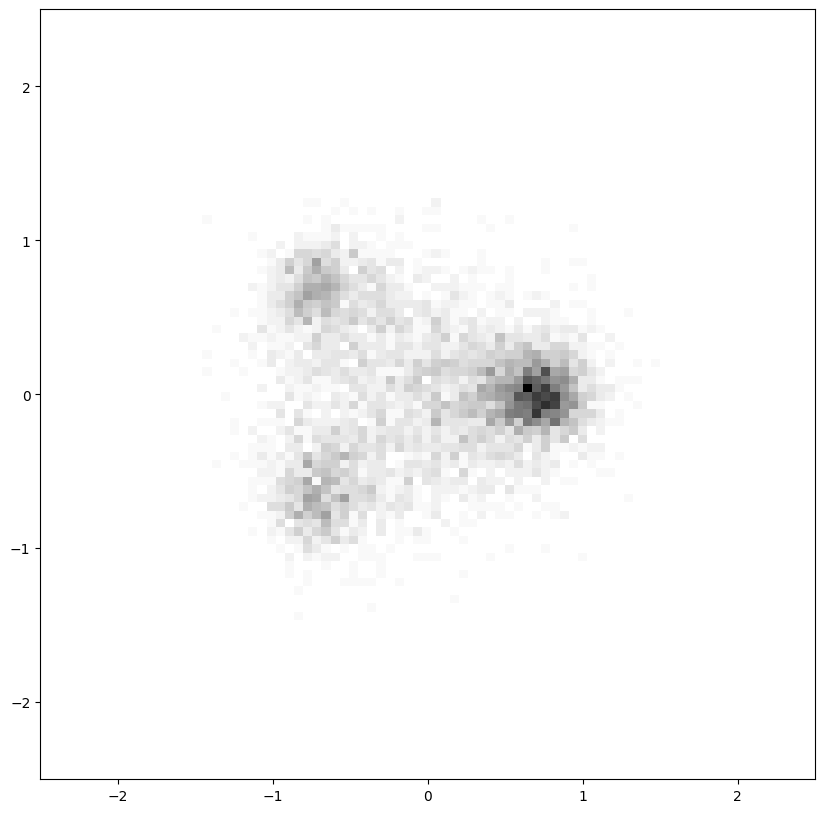

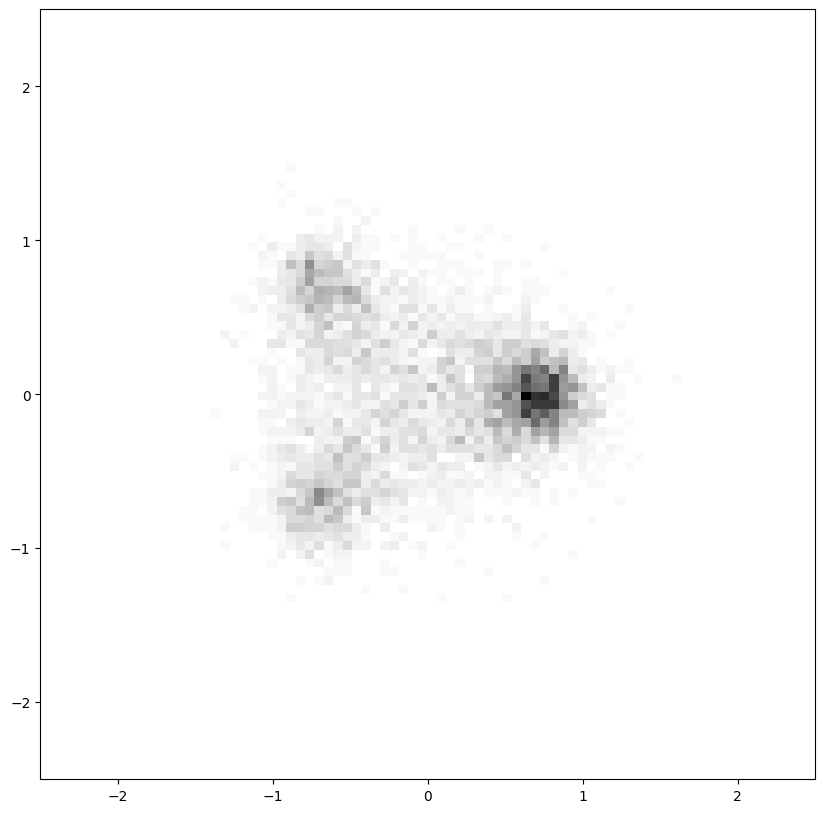

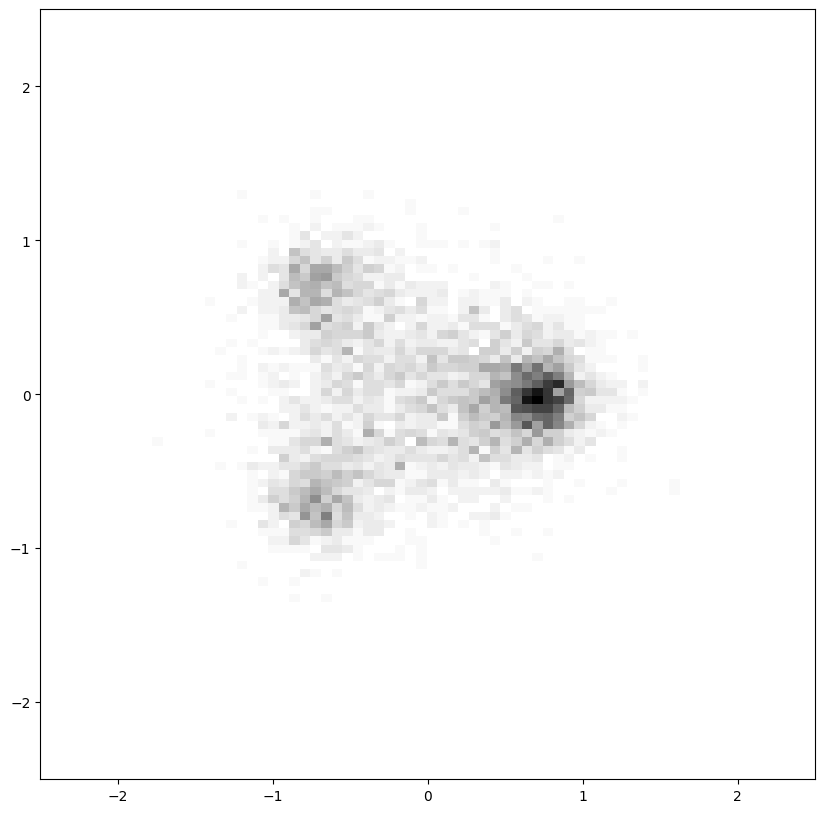

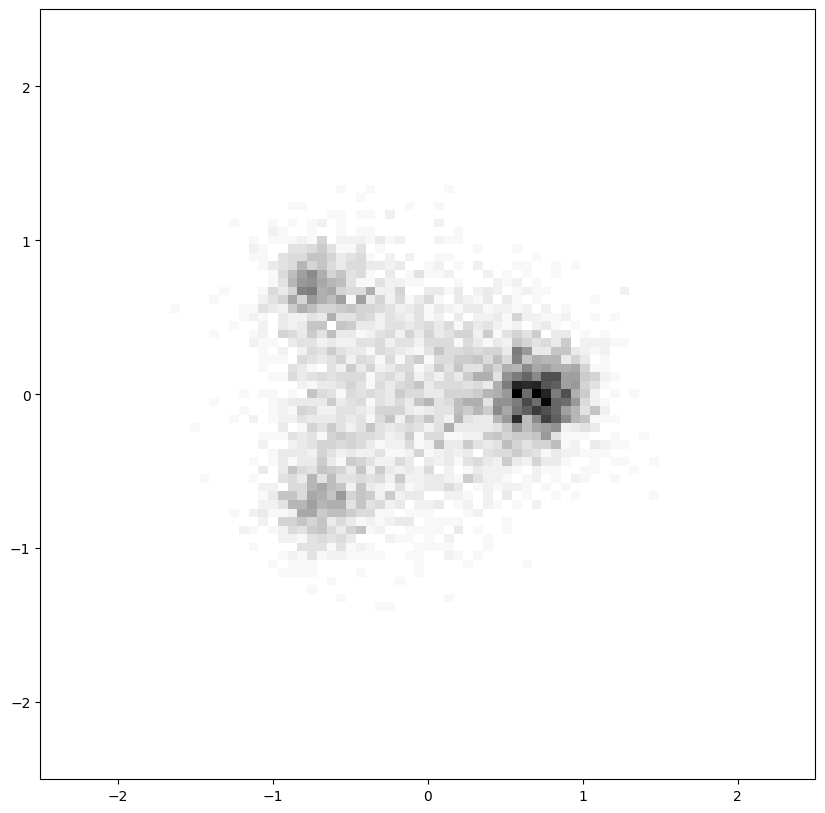

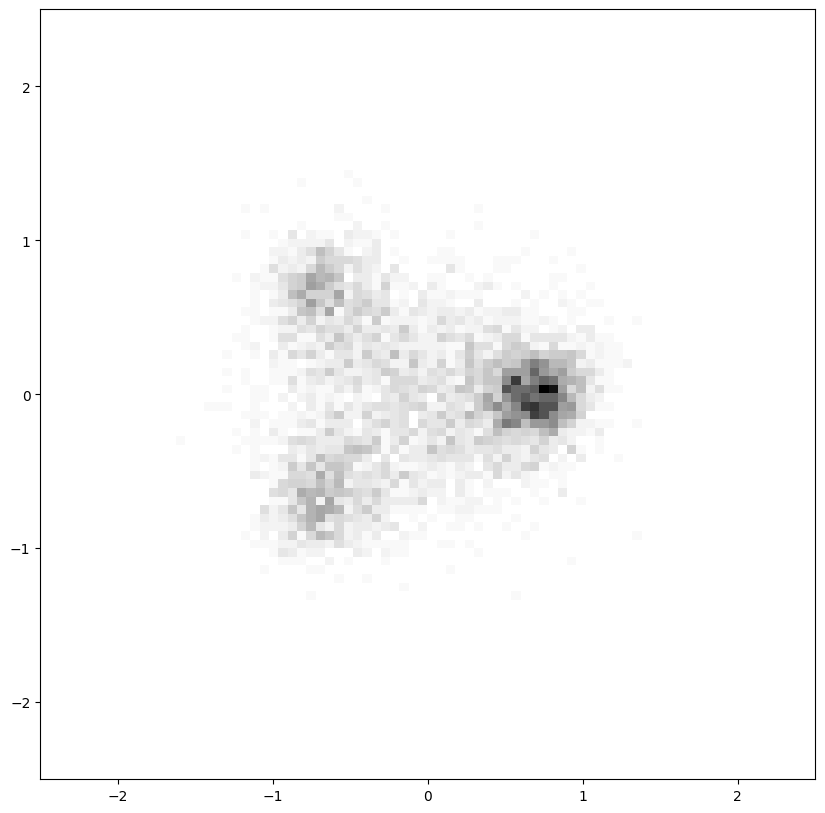

In [8]:
#Run the training loop
%matplotlib inline
from IPython.display import clear_output
from itertools import cycle
from accelerate import notebook_launcher

config.num_epochs = 300
config.batches_per_epoch = 20     
config.save_plot_epochs = 10
config.lr_primal = 0.002
config.lr_dual = 0.00
config.wandb_logging = True
config.T = 100
config.primal_batch_size = 512


mean1 = torch.Tensor([0.75, 0.0]).unsqueeze(0)

mean2_a = torch.Tensor([-0.75, 0.75]).unsqueeze(0)
mean2_b = torch.Tensor([-0.75, -0.75]).unsqueeze(0)


# cov1 = (torch.Tensor([[1.0, 0.8], [0.8, 1.0]])/10).unsqueeze(0)
cov1 = 0.025*torch.eye(2).unsqueeze(0)
cov2 = 0.025*torch.eye(2).unsqueeze(0)

covs = torch.concat((cov1, cov2), dim=0)

dataset1 = GaussianMixtureDataset(means = mean1, covariances = cov1, num_samples = 1000)
dataset2 = GaussianMixtureDataset(means = torch.concat((mean2_a, mean2_b), dim=0), covariances = covs, num_samples = 1000)



train_dataloader1 = DataLoader(dataset1, batch_size=config.primal_batch_size, shuffle=True)
train_dataloader2 = DataLoader(dataset2, batch_size=config.primal_batch_size, shuffle=True)


train_dataloaders = [train_dataloader1, train_dataloader2]

noise_scheduler = DDPMScheduler(num_train_timesteps=config.T, beta_start=0.0001, beta_end=0.05,clip_sample=False)

mu1 = 0.5

init_mus = torch.Tensor([mu1, 1 - mu1])

model_unconstrained = ResNetBlock2D()
optimizer = torch.optim.AdamW(model_unconstrained.parameters(), lr=config.lr_primal)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader1) * config.num_epochs),
)

args = (config, model_unconstrained, noise_scheduler, optimizer, train_dataloaders, lr_scheduler, init_mus)
notebook_launcher(train_loop, args, num_processes=1)


Constrained Model GMM means:
[[-0.58705949  0.53747879]
 [-0.58990778 -0.56644198]
 [ 0.50139222  0.00090003]]

Constrained Model GMM covariances:
[[[ 0.08097068 -0.01201495]
  [-0.01201495  0.07882857]]

 [[ 0.08355819  0.01194147]
  [ 0.01194147  0.07934135]]

 [[ 0.09986451  0.00478038]
  [ 0.00478038  0.07118177]]]

Unconstrained Model GMM means:
[[ 0.59885921 -0.00157047]
 [-0.52490147  0.51532992]
 [-0.50390042 -0.52095117]]

Unconstrained Model GMM covariances:
[[[ 0.07069438 -0.00130739]
  [-0.00130739  0.06400843]]

 [[ 0.10691062 -0.02253911]
  [-0.02253911  0.08952041]]

 [[ 0.10440073  0.02454068]
  [ 0.02454068  0.08631116]]]


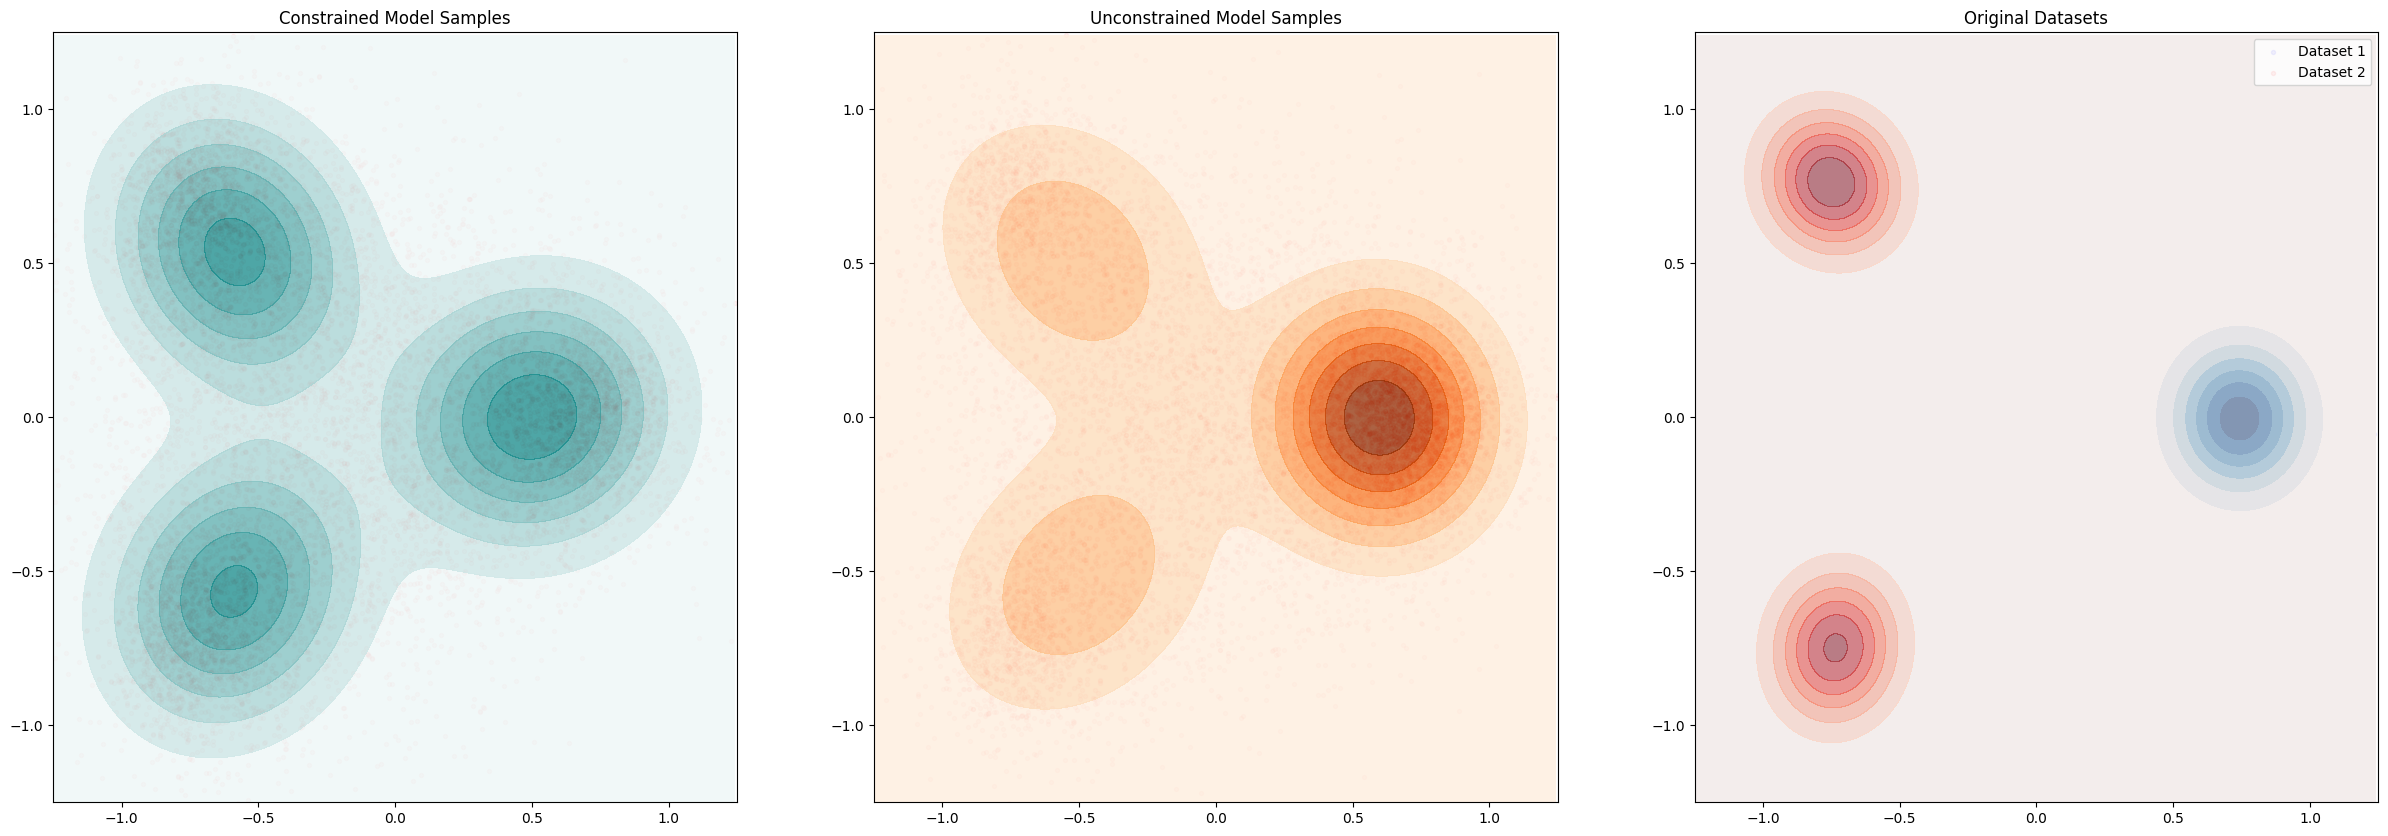

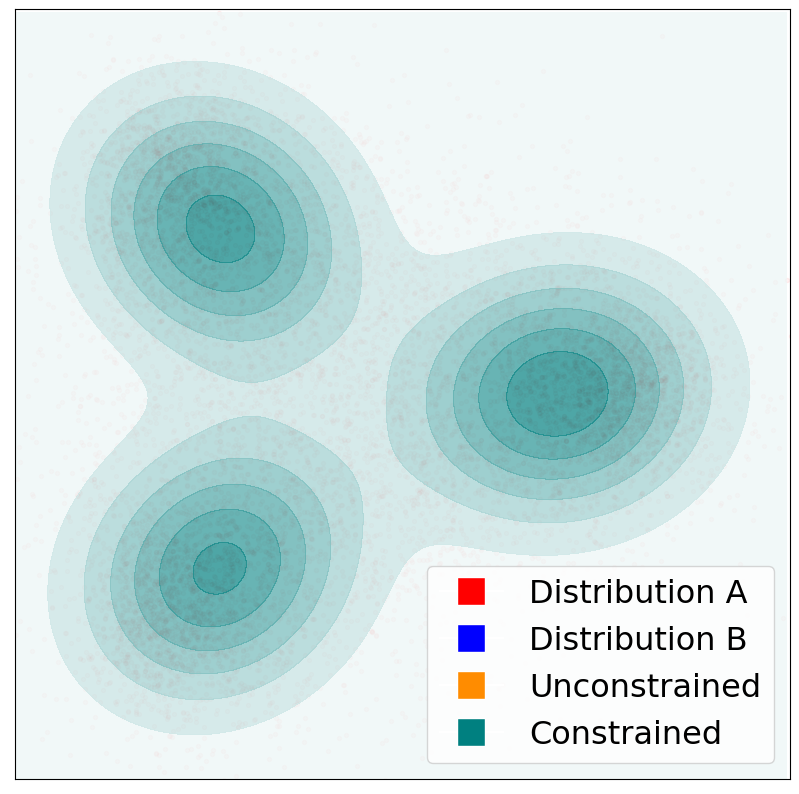

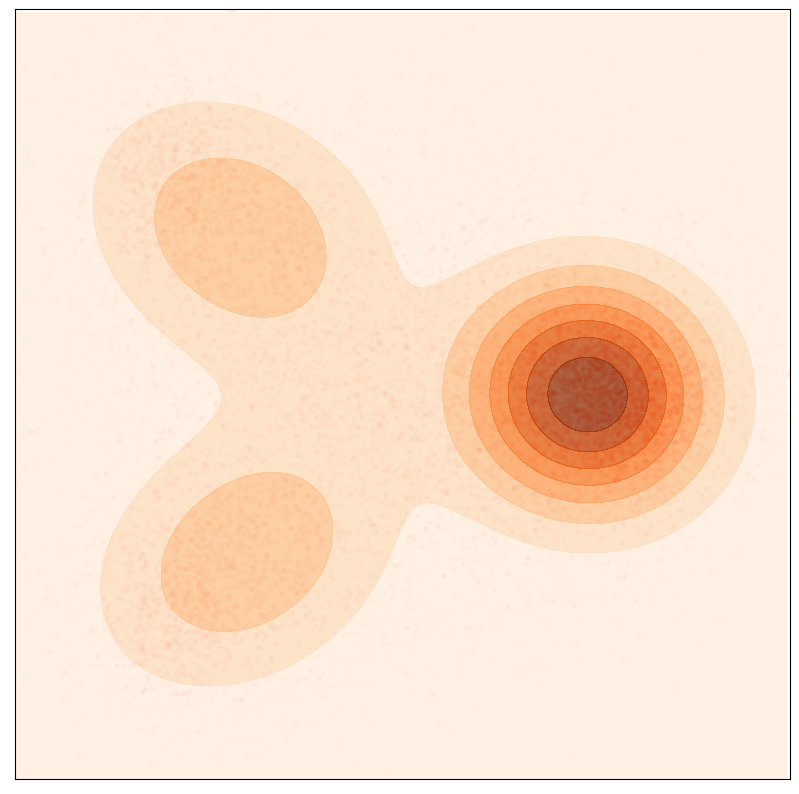

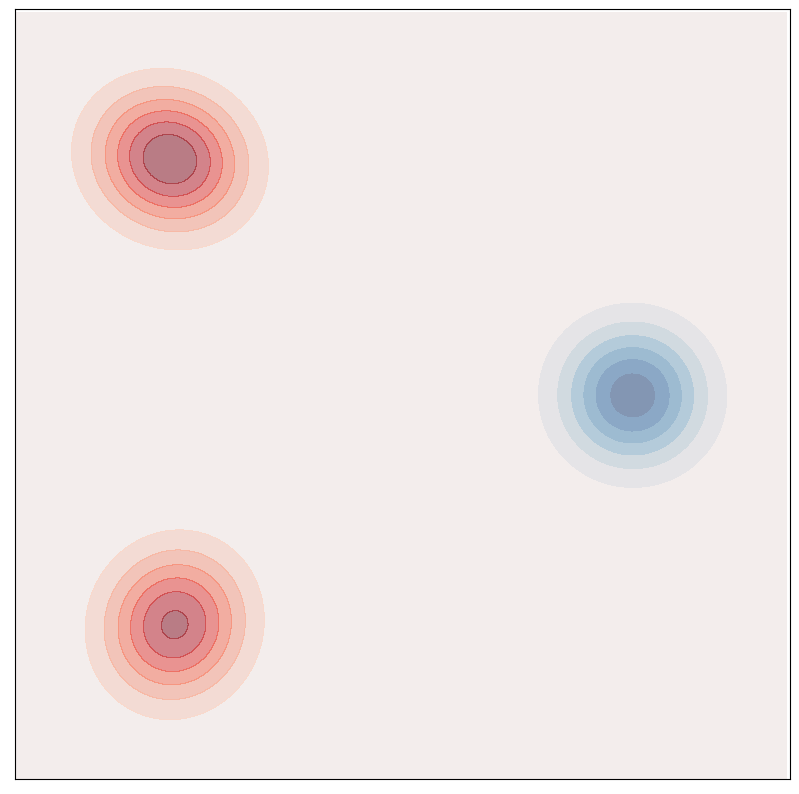

In [26]:
from matplotlib.colors import LinearSegmentedColormap as LinearSegradient
from sklearn.mixture import GaussianMixture


#  Sample from both models
images_constrained = sample_images_ddpm(model_constrained, noise_scheduler, batch_size=10000, num_inference_steps=config.T).detach().cpu().numpy()
images_unconstrained = sample_images_ddpm(model_unconstrained, noise_scheduler, batch_size=10000, num_inference_steps=config.T).detach().cpu().numpy()

heatmap_alpha = 0.75
scatter_alpha = 0.05

cmap = 'Oranges'
color = 'red'

xlim = 1.25
ylim = 1.25

levels = 7

# Create subplot with three plots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))

# Set plot limits

ax1.scatter(images_constrained[:, 0], images_constrained[:, 1], color = color, alpha = scatter_alpha, marker = '.')
# Fit GMM and plot for constrained model
gmm_constrained = GaussianMixture(n_components=3, random_state=42)
gmm_constrained.fit(images_constrained)

x, y = np.mgrid[-xlim:xlim:.01, -ylim:ylim:.01]
pos = np.dstack((x, y))
rv_constrained = np.exp(gmm_constrained.score_samples(pos.reshape(-1, 2)))
rv_constrained = rv_constrained.reshape(x.shape)

# Create a custom colormap from white to teal
colors = [(1, 1, 1), (0, 0.5, 0.5)]  # White to teal
n_bins = 100  # Number of color gradations
custom_cmap = LinearSegradient.from_list('custom_teal', colors, N=n_bins)

ax1.contourf(x, y, rv_constrained, levels=levels, cmap=custom_cmap, alpha=heatmap_alpha)
ax1.set_xlim(-xlim, xlim)
ax1.set_ylim(-ylim, ylim)
ax1.set_title('Constrained Model Samples')

# Fit GMM and plot for unconstrained model
ax2.scatter(images_unconstrained[:, 0], images_unconstrained[:, 1], color = color, alpha = scatter_alpha, marker = '.')
gmm_unconstrained = GaussianMixture(n_components=3, random_state=42)
gmm_unconstrained.fit(images_unconstrained)

rv_unconstrained = np.exp(gmm_unconstrained.score_samples(pos.reshape(-1, 2)))
rv_unconstrained = rv_unconstrained.reshape(x.shape)

ax2.contourf(x, y, rv_unconstrained, levels=levels, cmap=cmap, alpha=heatmap_alpha)
ax2.set_xlim(-xlim, xlim)
ax2.set_ylim(-ylim, ylim)
ax2.set_title('Unconstrained Model Samples')

# Plot original datasets

train_dataloader1 = DataLoader(dataset1, batch_size=10000, shuffle=True)
train_dataloader2 = DataLoader(dataset2, batch_size=10000, shuffle=True)

dataset1_samples = next(iter(train_dataloader1))
dataset2_samples = next(iter(train_dataloader2))

# Fit GMMs
gmm_dataset1 = GaussianMixture(n_components=1, random_state=42)
gmm_dataset2 = GaussianMixture(n_components=2, random_state=42)
gmm_dataset1.fit(dataset1_samples)
gmm_dataset2.fit(dataset2_samples)

# Plot samples and contours
ax3.scatter(dataset1_samples[:, 0], dataset1_samples[:, 1], color='blue', alpha=scatter_alpha, marker='.', label='Dataset 1')
ax3.scatter(dataset2_samples[:, 0], dataset2_samples[:, 1], color='red', alpha=scatter_alpha, marker='.', label='Dataset 2')

# Calculate and plot GMM contours
rv_dataset1 = np.exp(gmm_dataset1.score_samples(pos.reshape(-1, 2)))
rv_dataset1 = rv_dataset1.reshape(x.shape)
rv_dataset2 = np.exp(gmm_dataset2.score_samples(pos.reshape(-1, 2)))
rv_dataset2 = rv_dataset2.reshape(x.shape)

ax3.contourf(x, y, rv_dataset1, levels=levels, cmap='Blues', alpha=1.0)
ax3.contourf(x, y, rv_dataset2, levels=levels, cmap='Reds', alpha=0.5)

ax3.set_xlim(-xlim, xlim)
ax3.set_ylim(-ylim, ylim)
ax3.set_title('Original Datasets')
ax3.legend()

# Create three separate plots
plt.figure(figsize=(10, 10))
plt.scatter(images_constrained[:, 0], images_constrained[:, 1], color=color, alpha=scatter_alpha, marker='.')
plt.contourf(x, y, rv_constrained, levels=levels, cmap=custom_cmap, alpha=heatmap_alpha)
plt.xlim(-xlim, xlim)
plt.ylim(-ylim, ylim)
plt.xticks([])
plt.yticks([])

# Create custom legend handles
from matplotlib.lines import Line2D
marker_size = 20
legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor='red', label='Distribution A', markersize=marker_size),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', label='Distribution B', markersize=marker_size),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='darkorange', label='Unconstrained', markersize=marker_size),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='teal', label='Constrained', markersize=marker_size)
]
plt.legend(handles=legend_elements, fontsize=23)



plt.figure(figsize=(10, 10))
plt.scatter(images_unconstrained[:, 0], images_unconstrained[:, 1], color=color, alpha=scatter_alpha, marker='.')
plt.contourf(x, y, rv_unconstrained, levels=levels, cmap=cmap, alpha=heatmap_alpha)
plt.xlim(-xlim, xlim)
plt.ylim(-ylim, ylim)
plt.xticks([])
plt.yticks([])

plt.figure(figsize=(10, 10))
plt.scatter(dataset1_samples[:, 0], dataset1_samples[:, 1], color='blue', alpha=scatter_alpha, marker='.')
plt.scatter(dataset2_samples[:, 0], dataset2_samples[:, 1], color='red', alpha=scatter_alpha, marker='.')
plt.contourf(x, y, rv_dataset1, levels=levels, cmap='Blues', alpha=1.0)
plt.contourf(x, y, rv_dataset2, levels=levels, cmap='Reds', alpha=0.5)
plt.xlim(-xlim, xlim)
plt.ylim(-ylim, ylim)
plt.xticks([])
plt.yticks([])

print("Constrained Model GMM means:")
print(gmm_constrained.means_)
print("\nConstrained Model GMM covariances:")
print(gmm_constrained.covariances_)

print("\nUnconstrained Model GMM means:")
print(gmm_unconstrained.means_)
print("\nUnconstrained Model GMM covariances:")
print(gmm_unconstrained.covariances_)

In [ ]:
#Sanity check for noising process. (i.e. is t = T pure noise or not)

noise_scheduler = DDPMScheduler(num_train_timesteps=T, beta_start=0.0001, beta_end=0.05,clip_sample=False)

for batch in train_dataloader2:
    print(batch.shape)
    break  # Stop after the first batch

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
i = 0
for t in range(0, T, T//10):
    
    noise = torch.randn(batch.shape)
    timesteps = torch.LongTensor([t])
    noisy_image = noise_scheduler.add_noise(batch, noise, timesteps)
    axes[i].plot(noisy_image[:, 0], noisy_image[:, 1], '.') 
    axes[i].set_title(f"t = {t}")   
    i += 1
plt.tight_layout()
plt.show()
